# Streamlined Model Training




In [16]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')


In [ ]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Column constants
DEPTH_COL = "Depth(m)"
SPP_COL = "SPP Avg(bar)"
AP_COL = "Annular Press(barg)"

# Features
FEATURE_COLS = [
    DEPTH_COL, "TVD(m)", "Flow In Pum Avg(lpm)", "ROP Avg(m/hr)",
    "Torque Abs Avg(kN-m)", "WOB Avg(mton)", "RPM Surface Avg(rpm)",
    "Dens Mud(sg)"
]

# Model parameters
RF_PARAMS = {"n_estimators": 100, "max_depth": 10, "min_samples_split": 5, 
             "min_samples_leaf": 2, "random_state": 42}

# Leave-one-out configuration: Select which well to hold out (A, B, C, or D)
HOLDOUT_WELL = "D"  # Change this to test different wells

# Training mode filter: Select which mode to use for training
# Options: 
#   "drill" - filter to only "drill" mode data
#   "core_drill" - filter where is_core_drill == True
#   "all" or None - use all data points (no mode filtering)
TRAIN_MODE = "drill"  # Change this to "all", "drill", or "core_drill"

# Feature smoothing: choose whether to use rolling means for key signals
# Options:
#   "actual"  - use raw values
#   "rolling" - use rolling mean of the last ROLLING_WINDOW depth-ordered points
FEATURE_SMOOTHING_MODE = "actual"
ROLLING_WINDOW = 5
ROLLING_FEATURE_MAP = {
    SPP_COL: "SPP_rolling_mean",
    "ROP Avg(m/hr)": "ROP_rolling_mean",
    "Torque Abs Avg(kN-m)": "Torque_rolling_mean",
    "WOB Avg(mton)": "WOB_rolling_mean",
    "RPM Surface Avg(rpm)": "RPM_rolling_mean",
}

# Backward compatibility for SPP-specific handling
SPP_FEATURE_TYPE = "rolling" if FEATURE_SMOOTHING_MODE == "rolling" else "actual"

print(f"Holdout well: {HOLDOUT_WELL}")
print(f"Training mode: {TRAIN_MODE}")
print(f"SPP feature type for AP: {SPP_FEATURE_TYPE}")
print(f"Features: {len(FEATURE_COLS)}")
print(f"Feature smoothing: {FEATURE_SMOOTHING_MODE} (window={ROLLING_WINDOW if FEATURE_SMOOTHING_MODE == 'rolling' else 'n/a'})")


Holdout well: D
Training mode: drill
SPP feature type for AP: actual
Features: 8
Feature smoothing: actual (window=n/a)


In [18]:
# ============================================================================
# DATA LOADING
# ============================================================================

# Load all data
data_path = Path("../data/all_wells_processed.parquet")
if not data_path.exists():
    data_path = Path("../data/all_wells_processed.csv")
df_all = pd.read_parquet(data_path) if data_path.suffix == '.parquet' else pd.read_csv(data_path)

# Filter by mode
if TRAIN_MODE == "drill":
    if "mode" not in df_all.columns:
        raise ValueError("Column 'mode' not found in dataset. Cannot filter by mode.")
    df_filtered = df_all[df_all["mode"] == "drill"].copy()
    mode_label = "drill mode"
    print(f"Filtered to drill mode: {len(df_filtered)} rows (from {len(df_all)} total)")
elif TRAIN_MODE == "core_drill":
    if "is_core_drill" not in df_all.columns:
        raise ValueError("Column 'is_core_drill' not found in dataset. Please check the data.")
    df_filtered = df_all[df_all["is_core_drill"] == True].copy()
    mode_label = "core_drill mode"
    print(f"Filtered to is_core_drill=True: {len(df_filtered)} rows (from {len(df_all)} total)")
else:
    # Use all data (no mode filtering)
    df_filtered = df_all.copy()
    mode_label = "all modes"
    print(f"Using all data: {len(df_filtered)} rows (no mode filtering)")

# Create intra-well splits (80/20 per well) from filtered data
# Sort by depth to ensure proper ordering
intra_rows = []
for well_id in sorted(df_filtered["well_id"].unique()):
    well_data = df_filtered[df_filtered["well_id"] == well_id].copy()
    # Sort by depth to ensure proper ordering
    well_data = well_data.sort_values(by=DEPTH_COL).reset_index(drop=True)
    n_total = len(well_data)
    train_size = int(n_total * 0.8)
    
    train_well = well_data.iloc[:train_size].copy()
    test_well = well_data.iloc[train_size:].copy()
    
    train_well = train_well.assign(split="train", split_strategy="intra_well_80_20")
    test_well = test_well.assign(split="test", split_strategy="intra_well_80_20")
    
    intra_rows.append(pd.concat([train_well, test_well], ignore_index=True, sort=False))

df_intra = pd.concat(intra_rows, ignore_index=True, sort=False)
df_loo_all = df_filtered.copy()  # Will be split in Cell 7 for LOO

# Get list of all available wells
all_wells = sorted(df_intra["well_id"].unique())
print(f"Available wells: {all_wells}")

print(f"All data: {len(df_all)} rows")
print(f"Intra-well split ({mode_label}): {len(df_intra)} rows")
print(f"Leave-one-out data ({mode_label}): {len(df_loo_all)} rows")

# Verify 80/20 split per well
print("\n" + "="*80)
print(f"VERIFYING 80/20 SPLIT PER WELL ({mode_label})")
print("="*80)
for well_id in sorted(df_intra["well_id"].unique()):
    well_data = df_intra[df_intra["well_id"] == well_id]
    train_count = (well_data["split"] == "train").sum()
    test_count = (well_data["split"] == "test").sum()
    total = train_count + test_count
    train_pct = (train_count / total * 100) if total > 0 else 0
    test_pct = (test_count / total * 100) if total > 0 else 0
    print(f"Well {well_id}: Train={train_count} ({train_pct:.1f}%), Test={test_count} ({test_pct:.1f}%)")
    
    # Check depth separation (train should be shallower than test)
    if train_count > 0 and test_count > 0:
        train_depths = well_data[well_data["split"] == "train"][DEPTH_COL]
        test_depths = well_data[well_data["split"] == "test"][DEPTH_COL]
        if train_depths.max() > test_depths.min():
            print(f"  ⚠️  WARNING: Train/test depths overlap! Train max={train_depths.max():.1f}, Test min={test_depths.min():.1f}")
        else:
            print(f"  ✓ Depth separation OK: Train max={train_depths.max():.1f}, Test min={test_depths.min():.1f}")


Filtered to drill mode: 8913 rows (from 11442 total)
Available wells: ['A', 'B', 'C', 'D']
All data: 11442 rows
Intra-well split (drill mode): 8913 rows
Leave-one-out data (drill mode): 8913 rows

VERIFYING 80/20 SPLIT PER WELL (drill mode)
Well A: Train=1996 (80.0%), Test=500 (20.0%)
  ✓ Depth separation OK: Train max=4839.0, Test min=4840.0
Well B: Train=418 (79.9%), Test=105 (20.1%)
  ✓ Depth separation OK: Train max=6032.0, Test min=6033.0
Well C: Train=1409 (80.0%), Test=353 (20.0%)
  ✓ Depth separation OK: Train max=7877.0, Test min=7878.0
Well D: Train=3305 (80.0%), Test=827 (20.0%)
  ✓ Depth separation OK: Train max=6480.0, Test min=6481.0


In [19]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

def engineer_features(df):
    """Add engineered features if missing."""
    df = df.copy()
    if "mass_flow" not in df.columns:
        df["mass_flow"] = df["Flow In Pum Avg(lpm)"] * df["Dens Mud(sg)"]
    if "inclination_proxy" not in df.columns:
        df["inclination_proxy"] = (df[DEPTH_COL] - df["TVD(m)"]) / df[DEPTH_COL].clip(lower=1)
    if "torque_per_rpm" not in df.columns:
        df["torque_per_rpm"] = df["Torque Abs Avg(kN-m)"] / df["RPM Surface Avg(rpm)"].clip(lower=1)
    return df

def add_rolling_features(df, window=ROLLING_WINDOW):
    """Add rolling means (depth-ordered) for configured features per well."""
    df = df.copy()
    
    # Initialize target columns
    for target_col in ROLLING_FEATURE_MAP.values():
        df[target_col] = np.nan
    
    # Calculate rolling means per well
    for well_id in df["well_id"].unique():
        well_mask = df["well_id"] == well_id
        well_data = df[well_mask].copy()
        original_indices = well_data.index.values
        well_data = well_data.sort_values(by=DEPTH_COL).reset_index(drop=True)
        
        for source_col, target_col in ROLLING_FEATURE_MAP.items():
            if source_col not in well_data.columns:
                continue
            rolled = well_data[source_col].rolling(window=window, min_periods=1).mean()
            df.loc[original_indices, target_col] = rolled.values
    
    return df

def get_feature_column(col_name):
    """Return the column to use for a feature based on smoothing mode."""
    if FEATURE_SMOOTHING_MODE == "rolling" and col_name in ROLLING_FEATURE_MAP:
        return ROLLING_FEATURE_MAP[col_name]
    if col_name == SPP_COL and SPP_FEATURE_TYPE == "rolling":
        # Legacy path if callers still rely on SPP_FEATURE_TYPE directly
        return ROLLING_FEATURE_MAP.get(SPP_COL, "SPP_rolling_mean")
    return col_name

def get_base_feature_cols(target_col):
    """Base features before applying smoothing selection."""
    if target_col == AP_COL:
        return FEATURE_COLS + [SPP_COL]
    return FEATURE_COLS

df_all = engineer_features(df_all)
df_intra = engineer_features(df_intra)
df_loo_all = engineer_features(df_loo_all)

if FEATURE_SMOOTHING_MODE == "rolling":
    df_all = add_rolling_features(df_all, window=ROLLING_WINDOW)
    df_intra = add_rolling_features(df_intra, window=ROLLING_WINDOW)
    df_loo_all = add_rolling_features(df_loo_all, window=ROLLING_WINDOW)
    print("✓ Features engineered")
    print(f"✓ Rolling means added (window={ROLLING_WINDOW}) for {len(ROLLING_FEATURE_MAP)} features")
else:
    print("✓ Features engineered")
    print("✓ Using actual (unsmoothed) feature values")


✓ Features engineered
✓ Using actual (unsmoothed) feature values


In [20]:
# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def get_features_for_target(target_col):
    """Get feature columns for a target, respecting smoothing settings."""
    base_cols = get_base_feature_cols(target_col)
    if FEATURE_SMOOTHING_MODE == "rolling":
        return [get_feature_column(col) for col in base_cols]
    if target_col == AP_COL and SPP_FEATURE_TYPE == "rolling":
        # Legacy path if only SPP was smoothed
        return FEATURE_COLS + ["SPP_rolling_mean"]
    return base_cols

def make_model(model_type="linear"):
    """Create a model pipeline."""
    if model_type == "linear":
        return Pipeline([("scaler", StandardScaler()), ("regressor", LinearRegression())])
    elif model_type == "rf":
        return Pipeline([("scaler", StandardScaler()), 
                        ("regressor", RandomForestRegressor(**RF_PARAMS))])

def calculate_mape(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE) in percent."""
    # Avoid division by zero by using a small epsilon or filtering out zeros
    mask = np.abs(y_true) > 1e-6  # Filter out values very close to zero
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate(y_true, y_pred, well_ids=None):
    """Calculate metrics, optionally per well."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = calculate_mape(y_true, y_pred)
    
    if well_ids is not None:
        results = []
        for well_id in well_ids.unique():
            mask = well_ids == well_id
            y_true_well = y_true[mask]
            y_pred_well = y_pred[mask]
            results.append({
                "well_id": well_id,
                "mae": mean_absolute_error(y_true_well, y_pred_well),
                "rmse": np.sqrt(mean_squared_error(y_true_well, y_pred_well)),
                "r2": r2_score(y_true_well, y_pred_well),
                "mape": calculate_mape(y_true_well, y_pred_well),
                "n": mask.sum()
            })
        return pd.DataFrame(results), {"mae": mae, "rmse": rmse, "r2": r2, "mape": mape}
    return {"mae": mae, "rmse": rmse, "r2": r2, "mape": mape}

def train_and_evaluate(df_train, df_test, target_col, model_type="linear"):
    """Train model and return metrics."""
    # Filter valid data
    train = df_train[df_train[target_col].notna()].copy()
    test = df_test[df_test[target_col].notna()].copy()
    
    # Get features for this target (AP models include SPP, type depends on SPP_FEATURE_TYPE)
    feature_cols = get_features_for_target(target_col)
    
    # Prepare features (drop rows where any feature is missing)
    X_train = train[feature_cols].dropna()
    y_train = train.loc[X_train.index, target_col]
    X_test = test[feature_cols].dropna()
    y_test = test.loc[X_test.index, target_col]
    
    # Train
    model = make_model(model_type)
    model.fit(X_train, y_train)
    
    # Predict
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Evaluate
    train_metrics, train_overall = evaluate(y_train, train_pred, train.loc[X_train.index, "well_id"])
    test_metrics, test_overall = evaluate(y_test, test_pred, test.loc[X_test.index, "well_id"])
    
    return model, train_metrics, test_metrics, train_overall, test_overall


In [21]:
# ============================================================================
# TRAIN MODELS: DEPTH-BASED SPLIT
# ============================================================================
# Well-specific approach: Train one model per well on 80% of that well's data, test on remaining 20%
# Train both Linear Regression (baseline) and Random Forest models for comparison

models_depth = {}
results_depth = {}

for target_col, target_name in [(SPP_COL, "SPP"), (AP_COL, "AP")]:
    df_target = df_intra[df_intra[target_col].notna()].copy()
    
    # Get features for this target (AP models include SPP, type depends on SPP_FEATURE_TYPE)
    feature_cols = get_features_for_target(target_col)
    
    print(f"\n{target_name}: Training well-specific models (Linear Regression + Random Forest)")
    
    # Train a separate model for each well
    for well_id in sorted(df_target["well_id"].unique()):
        well_data = df_target[df_target["well_id"] == well_id].copy()
        
        # Get train and test data for this well
        train = well_data[well_data["split"] == "train"].copy()
        test = well_data[well_data["split"] == "test"].copy()
        
        if len(train) == 0 or len(test) == 0:
            print(f"  Skipping {target_name} {well_id}: insufficient data")
            continue
        
        # Train both Linear Regression and Random Forest models
        for model_type, model_name in [("linear", "LR"), ("rf", "RF")]:
            model, train_metrics, test_metrics, train_overall, test_overall = train_and_evaluate(
                train, test, target_col, model_type=model_type
            )
            
            key = f"{target_name}_{well_id}_{model_type}"
            models_depth[key] = model
            results_depth[key] = {"train": train_metrics, "test": test_metrics, 
                                 "train_overall": train_overall, "test_overall": test_overall,
                                 "model_type": model_type, "model_name": model_name}
        
        # Print comparison for this well
        lr_key = f"{target_name}_{well_id}_linear"
        rf_key = f"{target_name}_{well_id}_rf"
        lr_test = results_depth[lr_key]["test_overall"]
        rf_test = results_depth[rf_key]["test_overall"]
        
        print(f"  {target_name} {well_id}:")
        print(f"    LR:  Test R²={lr_test['r2']:.3f}, MAE={lr_test['mae']:.3f} bar, MAPE={lr_test.get('mape', np.nan):.2f}%")
        print(f"    RF:  Test R²={rf_test['r2']:.3f}, MAE={rf_test['mae']:.3f} bar, MAPE={rf_test.get('mape', np.nan):.2f}%")
        print(f"    Improvement: R²={rf_test['r2']-lr_test['r2']:+.3f}, MAE={lr_test['mae']-rf_test['mae']:+.3f} bar")



SPP: Training well-specific models (Linear Regression + Random Forest)
  SPP A:
    LR:  Test R²=-0.191, MAE=4.381 bar, MAPE=3.38%
    RF:  Test R²=-0.240, MAE=4.445 bar, MAPE=3.43%
    Improvement: R²=-0.050, MAE=-0.064 bar
  SPP B:
    LR:  Test R²=-0.802, MAE=1.714 bar, MAPE=1.29%
    RF:  Test R²=-0.587, MAE=1.747 bar, MAPE=1.30%
    Improvement: R²=+0.216, MAE=-0.034 bar
  SPP C:
    LR:  Test R²=0.560, MAE=3.003 bar, MAPE=2.51%
    RF:  Test R²=0.585, MAE=2.768 bar, MAPE=2.32%
    Improvement: R²=+0.025, MAE=+0.236 bar
  SPP D:
    LR:  Test R²=-3.313, MAE=14.848 bar, MAPE=12.00%
    RF:  Test R²=-8.190, MAE=20.061 bar, MAPE=15.80%
    Improvement: R²=-4.876, MAE=-5.213 bar

AP: Training well-specific models (Linear Regression + Random Forest)
  AP A:
    LR:  Test R²=-1.700, MAE=1.618 bar, MAPE=0.60%
    RF:  Test R²=-20.201, MAE=4.718 bar, MAPE=1.75%
    Improvement: R²=-18.502, MAE=-3.100 bar
  AP B:
    LR:  Test R²=-2.349, MAE=1.401 bar, MAPE=0.52%
    RF:  Test R²=-0.586, 

In [22]:
# ============================================================================
# TRAIN MODELS: LEAVE-ONE-WELL-OUT
# ============================================================================
# Train LOO models for all 4 wells: train on 3 wells, test on 1 well

models_loo = {}
results_loo = {}

# Use intra-well split data to create LOO splits (filtered by TRAIN_MODE setting)
# For each holdout well: train on all other wells, test on holdout well
for holdout_well in all_wells:
    print(f"\n{'='*80}")
    print(f"LEAVE-ONE-OUT: Holding out Well {holdout_well}")
    print(f"{'='*80}")
    
    # Create LOO split: train on all wells except holdout, test on holdout
    train_wells = [w for w in all_wells if w != holdout_well]
    df_loo_train = df_intra[df_intra["well_id"].isin(train_wells)].copy()
    df_loo_test = df_intra[df_intra["well_id"] == holdout_well].copy()
    
    print(f"  Training wells: {train_wells} ({len(df_loo_train)} samples)")
    print(f"  Test well: {holdout_well} ({len(df_loo_test)} samples)")
    
    for target_col, target_name in [(SPP_COL, "SPP"), (AP_COL, "AP")]:
        df_target_train = df_loo_train[df_loo_train[target_col].notna()].copy()
        df_target_test = df_loo_test[df_loo_test[target_col].notna()].copy()
        
        if len(df_target_train) == 0 or len(df_target_test) == 0:
            print(f"  Skipping {target_name}: insufficient data")
            continue
        
        # Train both Linear Regression and Random Forest models
        for model_type, model_name in [("linear", "LR"), ("rf", "RF")]:
            model, train_metrics, test_metrics, train_overall, test_overall = train_and_evaluate(
                df_target_train, df_target_test, target_col, model_type=model_type
            )
            
            key = f"{target_name}_loo_{holdout_well}_{model_type}"
            models_loo[key] = model
            results_loo[key] = {"train": train_metrics, "test": test_metrics,
                               "train_overall": train_overall, "test_overall": test_overall,
                               "model_type": model_type, "model_name": model_name}
        
        # Print comparison
        lr_key = f"{target_name}_loo_{holdout_well}_linear"
        rf_key = f"{target_name}_loo_{holdout_well}_rf"
        lr_test = results_loo[lr_key]["test_overall"]
        rf_test = results_loo[rf_key]["test_overall"]
        
        print(f"  {target_name} LOO (holdout {holdout_well}):")
        print(f"    LR:  Test R²={lr_test['r2']:.3f}, MAE={lr_test['mae']:.3f} bar, MAPE={lr_test.get('mape', np.nan):.2f}%")
        print(f"    RF:  Test R²={rf_test['r2']:.3f}, MAE={rf_test['mae']:.3f} bar, MAPE={rf_test.get('mape', np.nan):.2f}%")
        print(f"    Improvement: R²={rf_test['r2']-lr_test['r2']:+.3f}, MAE={lr_test['mae']-rf_test['mae']:+.3f} bar")



LEAVE-ONE-OUT: Holding out Well A
  Training wells: ['B', 'C', 'D'] (6417 samples)
  Test well: A (2496 samples)
  SPP LOO (holdout A):
    LR:  Test R²=0.483, MAE=6.278 bar, MAPE=5.49%
    RF:  Test R²=-0.946, MAE=13.461 bar, MAPE=11.33%
    Improvement: R²=-1.429, MAE=-7.183 bar
  AP LOO (holdout A):
    LR:  Test R²=0.867, MAE=1.487 bar, MAPE=0.57%
    RF:  Test R²=0.653, MAE=2.326 bar, MAPE=0.88%
    Improvement: R²=-0.214, MAE=-0.840 bar

LEAVE-ONE-OUT: Holding out Well B
  Training wells: ['A', 'C', 'D'] (8390 samples)
  Test well: B (523 samples)
  SPP LOO (holdout B):
    LR:  Test R²=-0.564, MAE=4.381 bar, MAPE=3.37%
    RF:  Test R²=-0.084, MAE=3.303 bar, MAPE=2.59%
    Improvement: R²=+0.480, MAE=+1.077 bar
  AP LOO (holdout B):
    LR:  Test R²=-1.385, MAE=2.953 bar, MAPE=1.11%
    RF:  Test R²=-8.913, MAE=6.165 bar, MAPE=2.32%
    Improvement: R²=-7.528, MAE=-3.212 bar

LEAVE-ONE-OUT: Holding out Well C
  Training wells: ['A', 'B', 'D'] (7151 samples)
  Test well: C (1762

In [23]:
# ============================================================================
# GENERATE PREDICTIONS (LOO models applied to their holdout wells)
# ============================================================================

df = df_all.copy()
# Create separate prediction columns for LR and RF
df["SPP_pred_lr"] = np.nan
df["SPP_pred_rf"] = np.nan
df["AP_pred_lr"] = np.nan
df["AP_pred_rf"] = np.nan
# Add AP predictions using SPP_pred instead of actual SPP
df["AP_pred_lr_predSPP"] = np.nan
df["AP_pred_rf_predSPP"] = np.nan

# Use LOO-trained models: each holdout model predicts its corresponding well
for target_col, target_name in [(SPP_COL, "SPP"), (AP_COL, "AP")]:
    feature_cols = get_features_for_target(target_col)
    
    for holdout_well in sorted(df_all["well_id"].unique()):
        for model_type in ["linear", "rf"]:
            key = f"{target_name}_loo_{holdout_well}_{model_type}"
            if key not in models_loo:
                continue
            
            model = models_loo[key]
            well_mask = df["well_id"] == holdout_well
            well_data = df[well_mask].copy()
            
            X_well = well_data[feature_cols].dropna()
            if len(X_well) > 0:
                pred = model.predict(X_well)
                pred_col = f"{target_name}_pred_lr" if model_type == "linear" else f"{target_name}_pred_rf"
                df.loc[X_well.index, pred_col] = pred
            
            # For AP models, also predict using SPP_pred instead of actual SPP
            if target_name == "AP":
                # Get SPP prediction column (use the same model type)
                spp_pred_col = "SPP_pred_lr" if model_type == "linear" else "SPP_pred_rf"
                
                # Create feature matrix with SPP_pred instead of actual SPP
                X_well_predSPP = X_well.copy()
                # Find which column is SPP (could be SPP_COL or SPP_rolling_mean depending on smoothing)
                spp_feature_col = get_feature_column(SPP_COL)
                if spp_feature_col in X_well_predSPP.columns:
                    # Replace SPP feature with SPP_pred
                    spp_pred_values = well_data.loc[X_well.index, spp_pred_col].values
                    X_well_predSPP[spp_feature_col] = spp_pred_values
                    
                    # Make predictions with SPP_pred
                    pred_predSPP = model.predict(X_well_predSPP)
                    pred_col_predSPP = f"{target_name}_pred_lr_predSPP" if model_type == "linear" else f"{target_name}_pred_rf_predSPP"
                    df.loc[X_well.index, pred_col_predSPP] = pred_predSPP

print(f"LR Predictions (LOO): SPP={df['SPP_pred_lr'].notna().sum()}, AP={df['AP_pred_lr'].notna().sum()}, AP_predSPP={df['AP_pred_lr_predSPP'].notna().sum()}")
print(f"RF Predictions (LOO): SPP={df['SPP_pred_rf'].notna().sum()}, AP={df['AP_pred_rf'].notna().sum()}, AP_predSPP={df['AP_pred_rf_predSPP'].notna().sum()}")


LR Predictions (LOO): SPP=10882, AP=10882, AP_predSPP=10882
RF Predictions (LOO): SPP=10882, AP=10882, AP_predSPP=10882


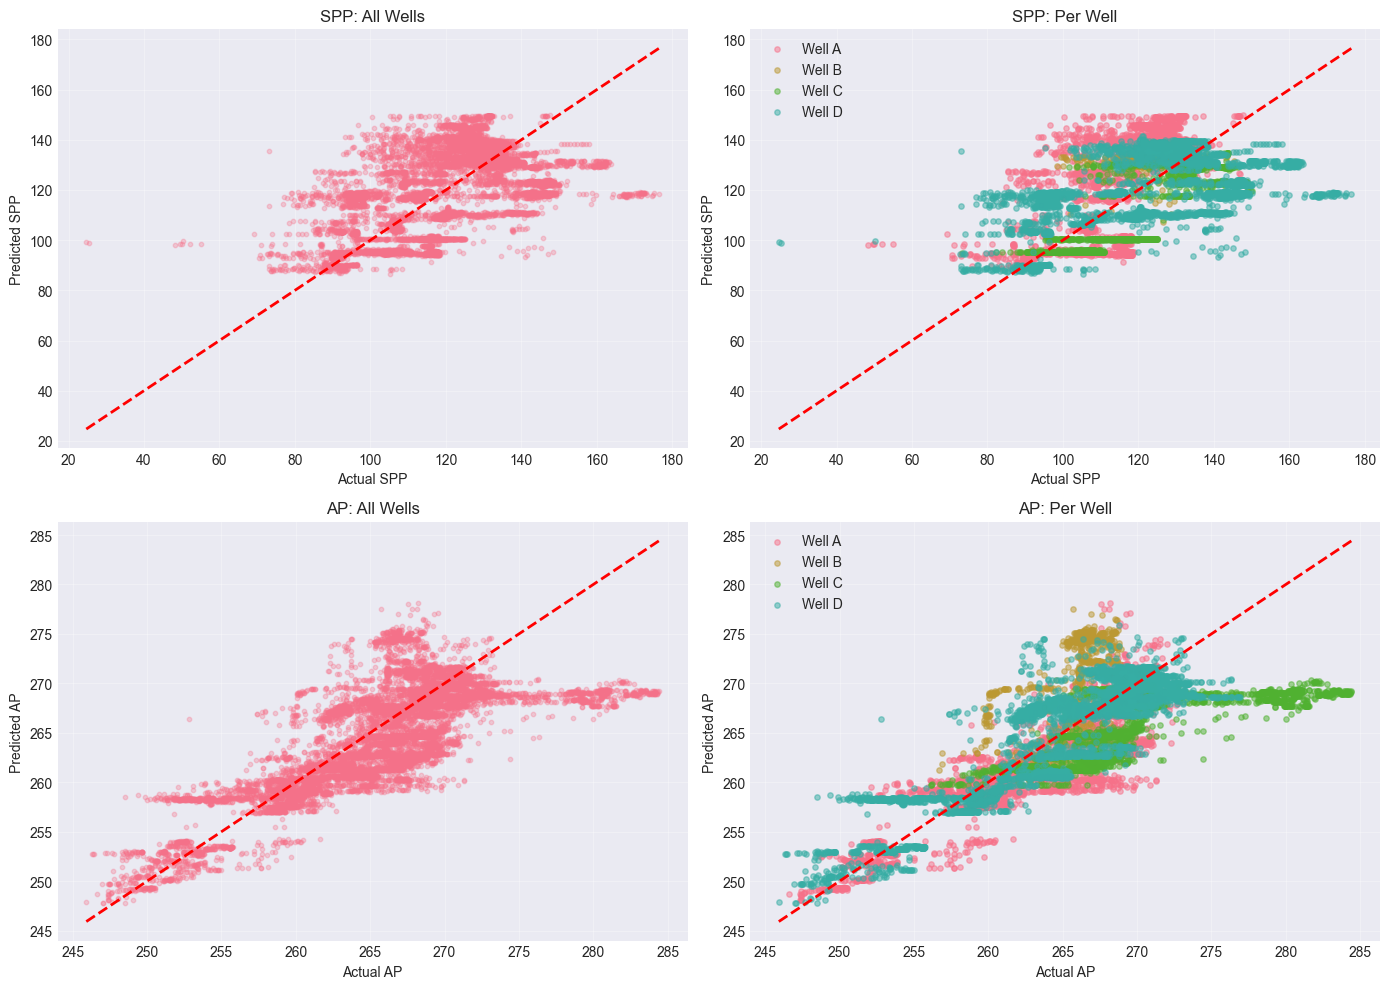

In [24]:
# ============================================================================
# VISUALIZATIONS
# ============================================================================

# Scatter plots: Predicted vs Actual
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (target_col, pred_col, title) in enumerate([
    (SPP_COL, "SPP_pred_rf", "SPP"), (AP_COL, "AP_pred_rf", "AP")
]):
    df_plot = df[df[target_col].notna() & df[pred_col].notna()]
    
    # Overall scatter
    ax = axes[idx, 0]
    ax.scatter(df_plot[target_col], df_plot[pred_col], alpha=0.3, s=10)
    min_val = min(df_plot[target_col].min(), df_plot[pred_col].min())
    max_val = max(df_plot[target_col].max(), df_plot[pred_col].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax.set_xlabel(f"Actual {title}")
    ax.set_ylabel(f"Predicted {title}")
    ax.set_title(f"{title}: All Wells")
    ax.grid(True, alpha=0.3)
    
    # Per well
    ax = axes[idx, 1]
    for well_id in sorted(df_plot["well_id"].unique()):
        well_data = df_plot[df_plot["well_id"] == well_id]
        ax.scatter(well_data[target_col], well_data[pred_col], alpha=0.5, s=15, label=f"Well {well_id}")
    min_val = min(df_plot[target_col].min(), df_plot[pred_col].min())
    max_val = max(df_plot[target_col].max(), df_plot[pred_col].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax.set_xlabel(f"Actual {title}")
    ax.set_ylabel(f"Predicted {title}")
    ax.set_title(f"{title}: Per Well")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


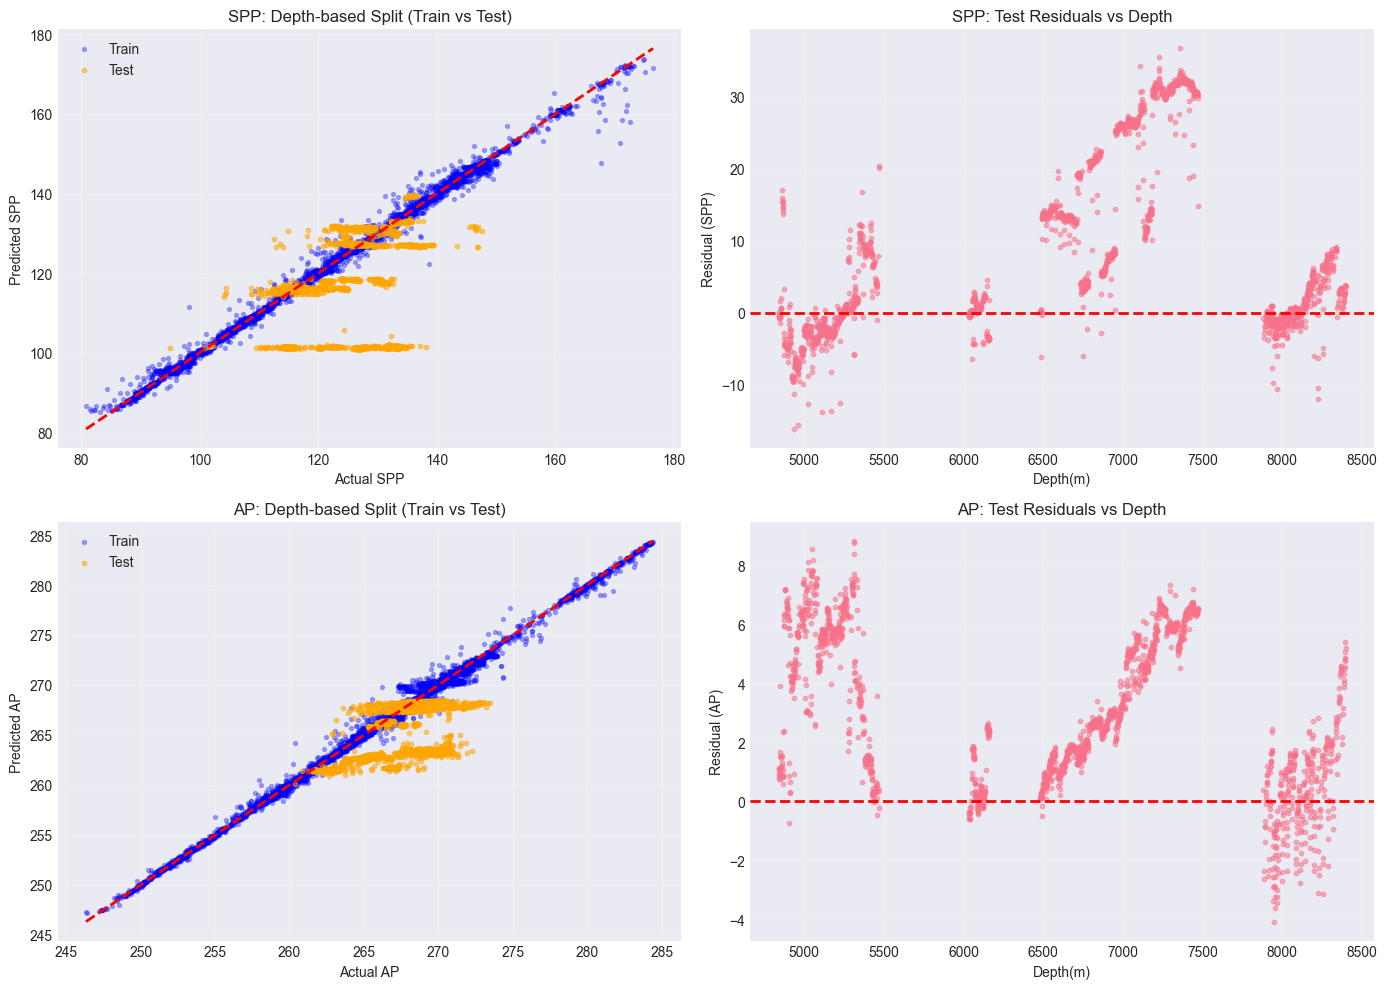

In [25]:
# Train/Test comparison for depth-based split
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (target_col, target_name) in enumerate([(SPP_COL, "SPP"), (AP_COL, "AP")]):
    df_target = df_intra[df_intra[target_col].notna()].copy()
    
    # Get features for this target (AP models include SPP)
    feature_cols = get_features_for_target(target_col)
    
    # Generate predictions for train/test using well-specific models
    df_target["pred_train"] = np.nan
    df_target["pred_test"] = np.nan
    
    for well_id in sorted(df_target["well_id"].unique()):
        # Get well-specific Random Forest model
        key = f"{target_name}_{well_id}_rf"
        if key not in models_depth:
            continue
        
        model = models_depth[key]
        well_data = df_target[df_target["well_id"] == well_id].copy()
        
        for split_type in ["train", "test"]:
            split_data = well_data[well_data["split"] == split_type]
            X_split = split_data[feature_cols].dropna()
            if len(X_split) > 0:
                pred = model.predict(X_split)
                df_target.loc[X_split.index, f"pred_{split_type}"] = pred
    
    # Plot train vs test
    ax = axes[idx, 0]
    train_data = df_target[(df_target["split"] == "train") & df_target["pred_train"].notna()]
    test_data = df_target[(df_target["split"] == "test") & df_target["pred_test"].notna()]
    
    if len(train_data) > 0:
        ax.scatter(train_data[target_col], train_data["pred_train"], alpha=0.3, s=8, label='Train', color='blue')
    if len(test_data) > 0:
        ax.scatter(test_data[target_col], test_data["pred_test"], alpha=0.5, s=10, label='Test', color='orange')
    
    if len(train_data) > 0 or len(test_data) > 0:
        all_data = pd.concat([train_data, test_data])
        min_val = min(all_data[target_col].min(), 
                     all_data[["pred_train", "pred_test"]].min().min())
        max_val = max(all_data[target_col].max(), 
                     all_data[["pred_train", "pred_test"]].max().max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    ax.set_xlabel(f"Actual {target_name}")
    ax.set_ylabel(f"Predicted {target_name}")
    ax.set_title(f"{target_name}: Depth-based Split (Train vs Test)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Residuals by depth
    ax = axes[idx, 1]
    test_data = df_target[(df_target["split"] == "test") & df_target["pred_test"].notna()]
    if len(test_data) > 0:
        residuals = test_data[target_col] - test_data["pred_test"]
        ax.scatter(test_data[DEPTH_COL], residuals, alpha=0.5, s=10)
        ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
        ax.set_xlabel(DEPTH_COL)
        ax.set_ylabel(f"Residual ({target_name})")
        ax.set_title(f"{target_name}: Test Residuals vs Depth")
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


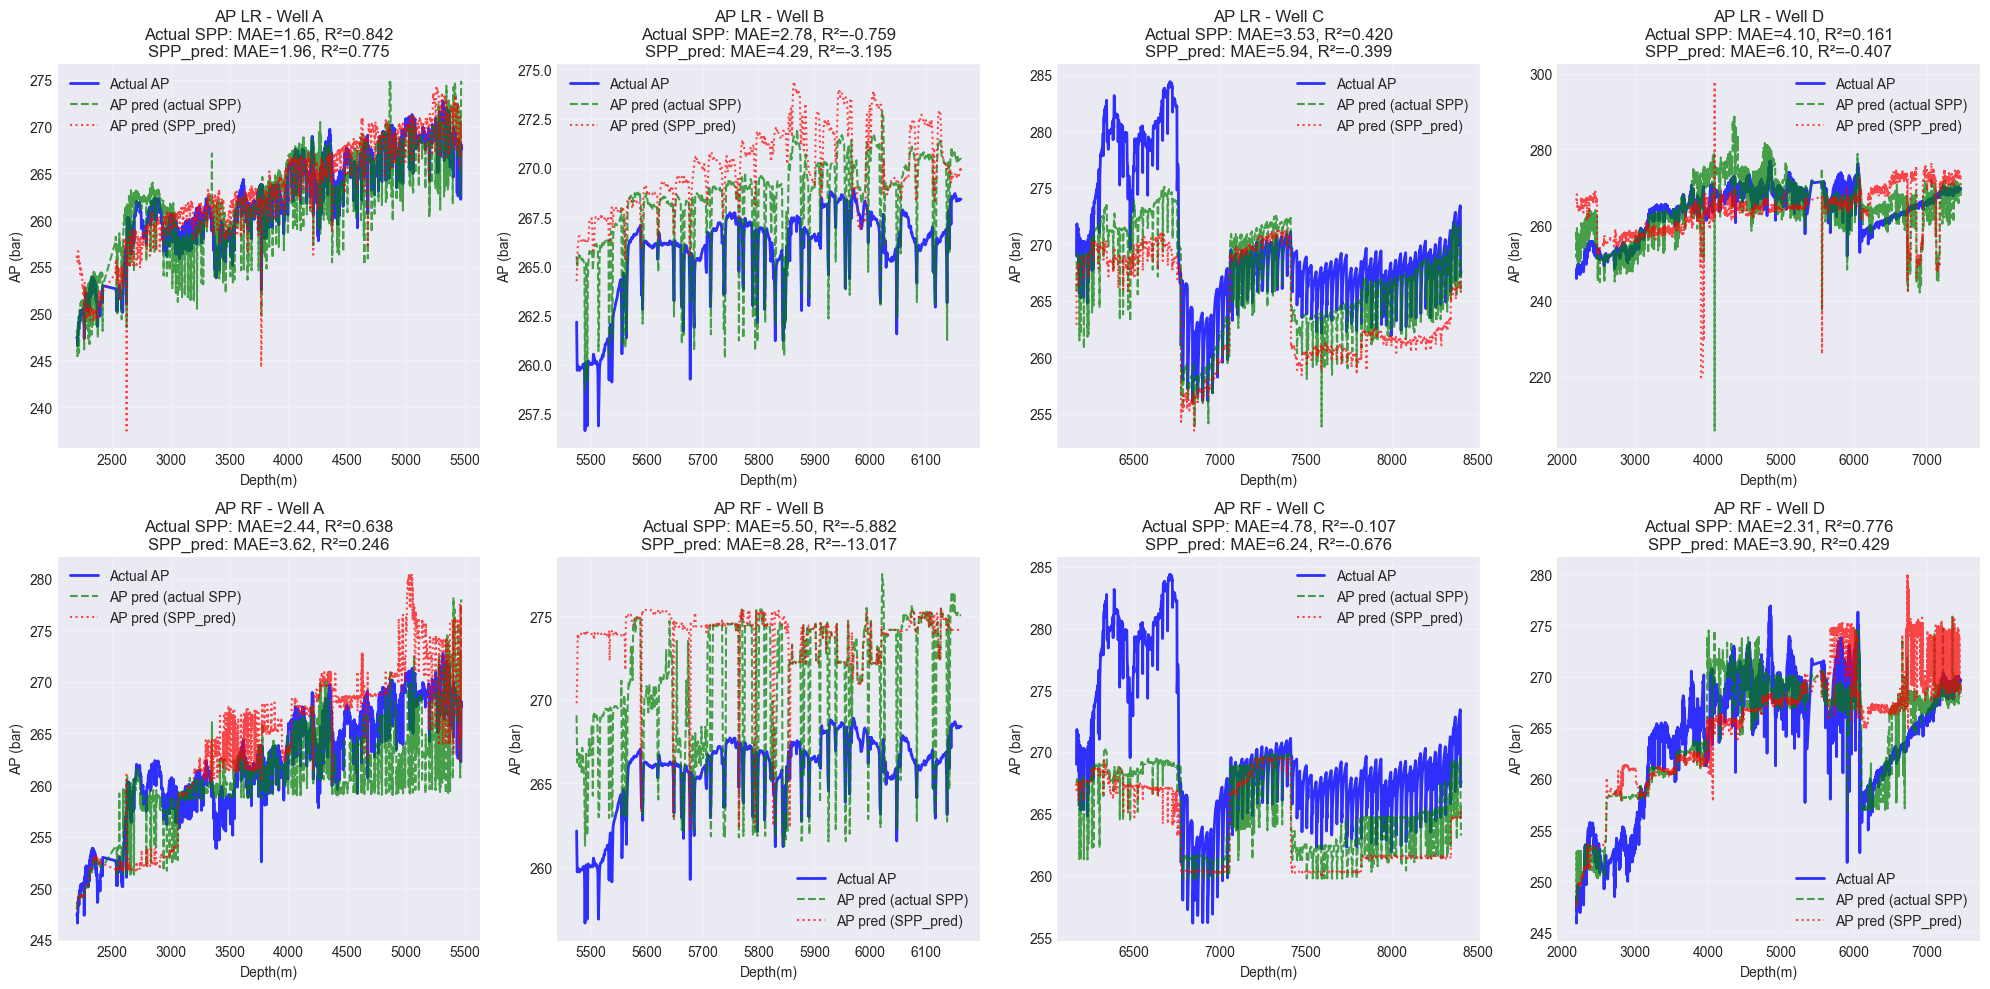

In [32]:
# ============================================================================
# VISUALIZATION: AP PREDICTIONS WITH ACTUAL SPP vs AP PREDICTIONS WITH SPP_pred
# ============================================================================
# Compare AP predictions using actual SPP vs using predicted SPP for each well

fig, axes = plt.subplots(2, len(all_wells), figsize=(5*len(all_wells), 10))

for model_idx, (model_type, model_label) in enumerate([("linear", "LR"), ("rf", "RF")]):
    for well_idx, well_id in enumerate(sorted(all_wells)):
        ax = axes[model_idx, well_idx]
        
        # Get data for this well
        well_mask = df["well_id"] == well_id
        well_data = df[well_mask].copy()
        
        # Filter to rows with all required data
        pred_col_actualSPP = f"AP_pred_lr" if model_type == "linear" else f"AP_pred_rf"
        pred_col_predSPP = f"AP_pred_lr_predSPP" if model_type == "linear" else f"AP_pred_rf_predSPP"
        
        valid_mask = (well_data[AP_COL].notna() & 
                     well_data[pred_col_actualSPP].notna() & 
                     well_data[pred_col_predSPP].notna())
        
        if valid_mask.sum() == 0:
            ax.text(0.5, 0.5, f"No data\nfor Well {well_id}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"AP {model_label} - Well {well_id}")
            continue
        
        plot_data = well_data[valid_mask].copy()
        plot_data = plot_data.sort_values(by=DEPTH_COL)
        
        depths = plot_data[DEPTH_COL].values
        y_actual = plot_data[AP_COL].values
        y_pred_actualSPP = plot_data[pred_col_actualSPP].values
        y_pred_predSPP = plot_data[pred_col_predSPP].values
        
        # Plot actual, predicted with actual SPP, and predicted with SPP_pred
        ax.plot(depths, y_actual, 'b-', label='Actual AP', linewidth=2, alpha=0.8)
        ax.plot(depths, y_pred_actualSPP, 'g--', label='AP pred (actual SPP)', linewidth=1.5, alpha=0.7)
        ax.plot(depths, y_pred_predSPP, 'r:', label='AP pred (SPP_pred)', linewidth=1.5, alpha=0.7)
        
        # Calculate metrics
        mae_actualSPP = mean_absolute_error(y_actual, y_pred_actualSPP)
        r2_actualSPP = r2_score(y_actual, y_pred_actualSPP)
        mae_predSPP = mean_absolute_error(y_actual, y_pred_predSPP)
        r2_predSPP = r2_score(y_actual, y_pred_predSPP)
        
        ax.set_xlabel(DEPTH_COL)
        ax.set_ylabel("AP (bar)")
        ax.set_title(f"AP {model_label} - Well {well_id}\nActual SPP: MAE={mae_actualSPP:.2f}, R²={r2_actualSPP:.3f}\nSPP_pred: MAE={mae_predSPP:.2f}, R²={r2_predSPP:.3f}")
        ax.grid(True, alpha=0.3)
        ax.legend()

plt.tight_layout()
fig.savefig(f"../figures/models_n_preds/predSPP_in_AP_{TRAIN_MODE}_data_{FEATURE_SMOOTHING_MODE}_features_AP_actualSPP_vs_predSPP.pdf")
plt.show()


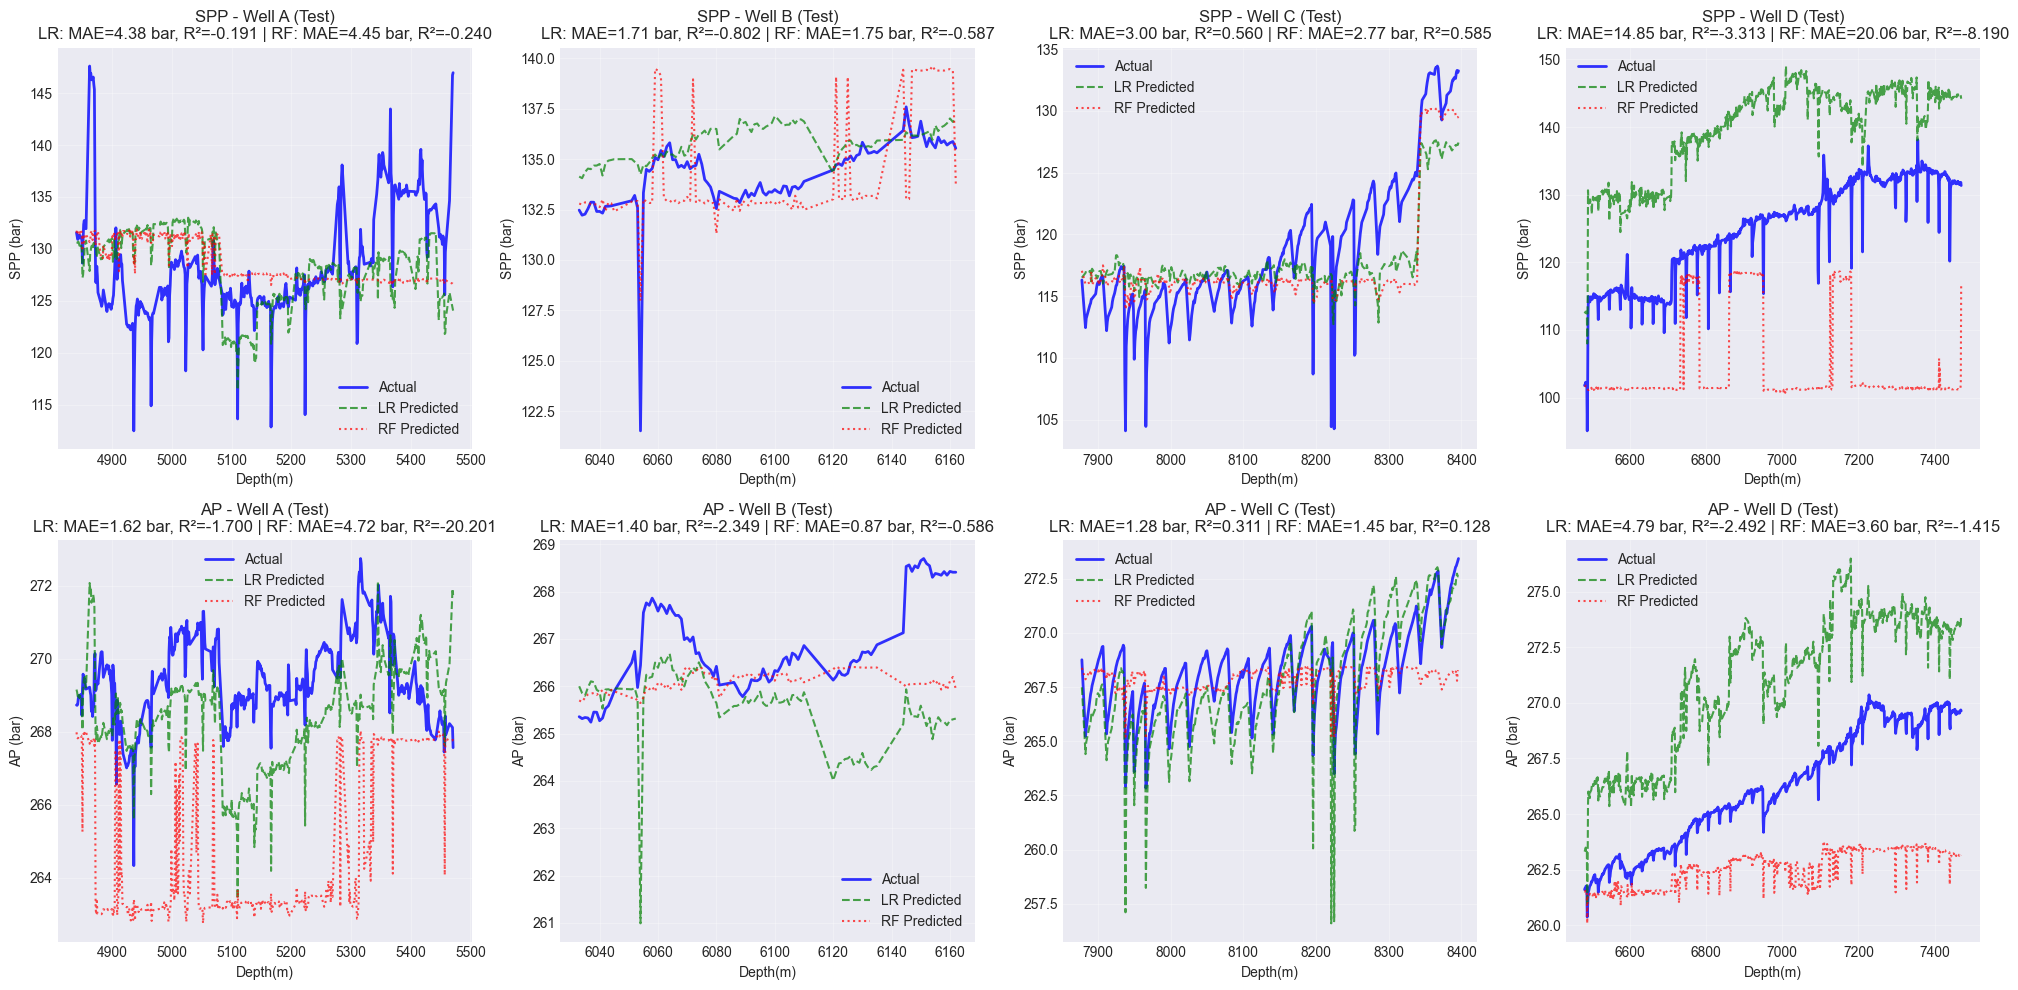

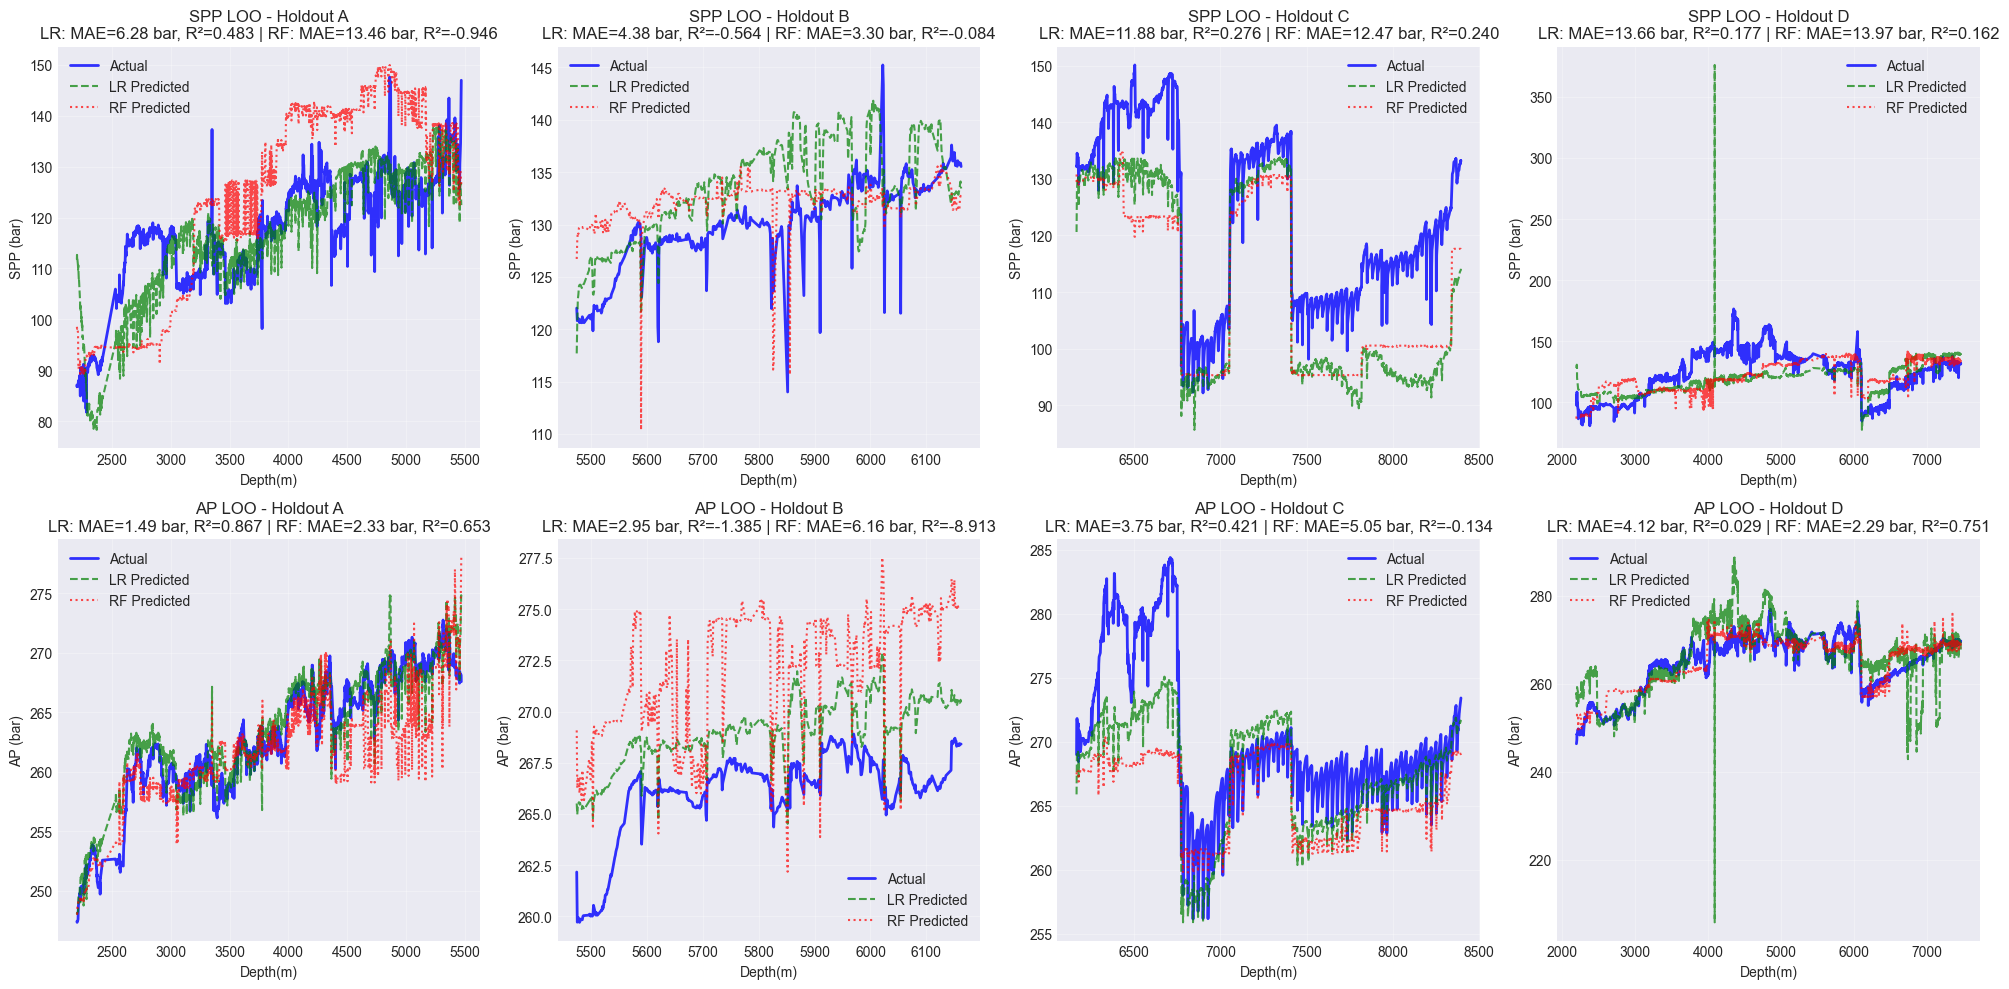

Saved: ../figures/models_n_preds/well_A_intra_test_drill_data_actual_features.pdf


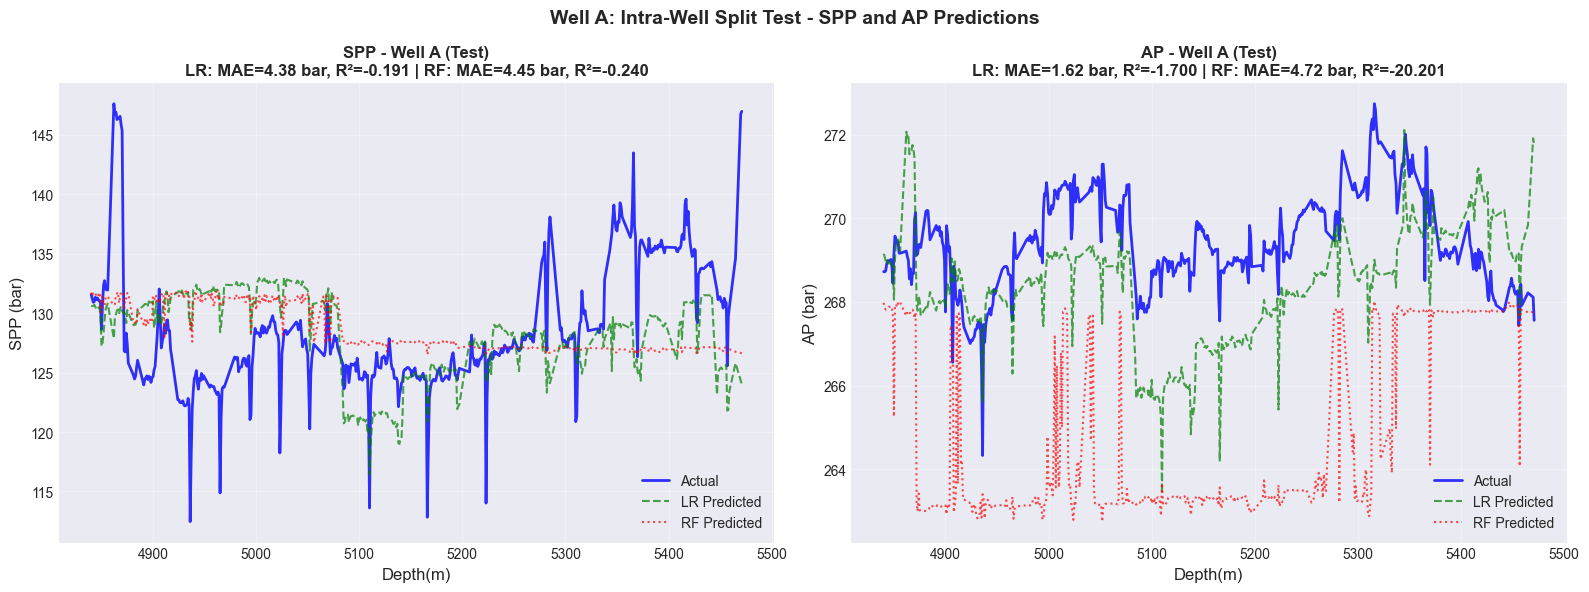

In [ ]:
# ============================================================================
# DEPTH-SERIES PLOTS: TEST DATA ONLY
# ============================================================================
# Intra-well split: Test portion (20%) of each well - Actual vs Predicted vs Depth
# LOO: Holdout well test data - Actual vs Predicted vs Depth

# 1. Intra-well split: Test portion for each well
fig, axes = plt.subplots(2, len(all_wells), figsize=(5*len(all_wells), 10))

for target_idx, (target_col, target_name) in enumerate([(SPP_COL, "SPP"), (AP_COL, "AP")]):
    df_target = df_intra[df_intra[target_col].notna()].copy()
    
    # Get features for this target
    feature_cols = get_features_for_target(target_col)
    
    # Plot test data for each well using both LR and RF models
    for well_idx, well_id in enumerate(sorted(df_target["well_id"].unique())):
        ax = axes[target_idx, well_idx]
        
        # Get well-specific Linear Regression and Random Forest models
        lr_key = f"{target_name}_{well_id}_linear"
        rf_key = f"{target_name}_{well_id}_rf"
        
        if lr_key not in models_depth or rf_key not in models_depth:
            ax.text(0.5, 0.5, f"No model\nfor Well {well_id}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{target_name} - Well {well_id} (Test)")
            continue
        
        lr_model = models_depth[lr_key]
        rf_model = models_depth[rf_key]
        
        # Get test data for this well
        well_test = df_target[(df_target["well_id"] == well_id) & 
                              (df_target["split"] == "test")].copy()
        
        if len(well_test) == 0:
            ax.text(0.5, 0.5, f"No test data\nfor Well {well_id}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{target_name} - Well {well_id} (Test)")
            continue
        
        # Generate predictions from both models
        X_test = well_test[feature_cols].dropna()
        if len(X_test) > 0:
            # Get corresponding depth and actual values
            test_data = well_test.loc[X_test.index].copy()
            test_data = test_data.sort_values(by=DEPTH_COL)  # Sort by depth for line plot
            
            # Re-extract features in sorted order for prediction
            X_test_sorted = test_data[feature_cols]
            y_test = test_data[target_col]
            y_pred_lr = lr_model.predict(X_test_sorted)
            y_pred_rf = rf_model.predict(X_test_sorted)
            depths = test_data[DEPTH_COL]
            
            # Plot actual, LR predicted, and RF predicted vs depth
            ax.plot(depths, y_test, 'b-', label='Actual', linewidth=2, alpha=0.8)
            ax.plot(depths, y_pred_lr, 'g--', label='LR Predicted', linewidth=1.5, alpha=0.7)
            ax.plot(depths, y_pred_rf, 'r:', label='RF Predicted', linewidth=1.5, alpha=0.7)
            
            # Calculate metrics for both models
            mae_lr = mean_absolute_error(y_test, y_pred_lr)
            r2_lr = r2_score(y_test, y_pred_lr)
            mae_rf = mean_absolute_error(y_test, y_pred_rf)
            r2_rf = r2_score(y_test, y_pred_rf)
            
            ax.set_xlabel(DEPTH_COL)
            ax.set_ylabel(f"{target_name} (bar)")
            ax.set_title(f"{target_name} - Well {well_id} (Test)\nLR: MAE={mae_lr:.2f} bar, R²={r2_lr:.3f} | RF: MAE={mae_rf:.2f} bar, R²={r2_rf:.3f}")
            ax.grid(True, alpha=0.3)
            ax.legend()
            # Do not invert the x-axis; now shallowest (smallest) depth is at left
            # (Removed: ax.invert_xaxis())

plt.tight_layout()
#fig.savefig(f"predSPP_in_AP_{TRAIN_MODE}_data_{FEATURE_SMOOTHING_MODE}_features_intra_well.pdf")
plt.show()

# 2. LOO: Holdout well test data
fig, axes = plt.subplots(2, len(all_wells), figsize=(5*len(all_wells), 10))

for target_idx, (target_col, target_name) in enumerate([(SPP_COL, "SPP"), (AP_COL, "AP")]):
    # Plot LOO test data for each holdout well using both LR and RF models
    for well_idx, holdout_well in enumerate(all_wells):
        ax = axes[target_idx, well_idx]
        
        # Find the LOO Linear Regression and Random Forest models for this holdout well
        lr_key = f"{target_name}_loo_{holdout_well}_linear"
        rf_key = f"{target_name}_loo_{holdout_well}_rf"
        
        if lr_key not in models_loo or rf_key not in models_loo:
            ax.text(0.5, 0.5, f"No LOO model\nfor {target_name}\nholdout {holdout_well}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{target_name} LOO - Holdout {holdout_well}")
            continue
        
        lr_model = models_loo[lr_key]
        rf_model = models_loo[rf_key]
        
        # Get test data for this holdout well from intra-well split data
        # (LOO test is the entire holdout well)
        well_test = df_intra[(df_intra["well_id"] == holdout_well) & 
                            (df_intra[target_col].notna())].copy()
        
        if len(well_test) == 0:
            ax.text(0.5, 0.5, f"No test data\nfor Well {holdout_well}", 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{target_name} LOO - Holdout {holdout_well}")
            continue
        
        # Get features for this target
        feature_cols = get_features_for_target(target_col)
        
        # Generate predictions from both models
        X_test = well_test[feature_cols].dropna()
        if len(X_test) > 0:
            # Get corresponding depth and actual values
            test_data = well_test.loc[X_test.index].copy()
            test_data = test_data.sort_values(by=DEPTH_COL)  # Sort by depth for line plot
            
            # Re-extract features in sorted order for prediction
            X_test_sorted = test_data[feature_cols]
            y_test = test_data[target_col]
            y_pred_lr = lr_model.predict(X_test_sorted)
            y_pred_rf = rf_model.predict(X_test_sorted)
            depths = test_data[DEPTH_COL]
            
            # Plot actual, LR predicted, and RF predicted vs depth
            ax.plot(depths, y_test, 'b-', label='Actual', linewidth=2, alpha=0.8)
            ax.plot(depths, y_pred_lr, 'g--', label='LR Predicted', linewidth=1.5, alpha=0.7)
            ax.plot(depths, y_pred_rf, 'r:', label='RF Predicted', linewidth=1.5, alpha=0.7)
            
            # Calculate metrics for both models
            mae_lr = mean_absolute_error(y_test, y_pred_lr)
            r2_lr = r2_score(y_test, y_pred_lr)
            mae_rf = mean_absolute_error(y_test, y_pred_rf)
            r2_rf = r2_score(y_test, y_pred_rf)
            
            ax.set_xlabel(DEPTH_COL)
            ax.set_ylabel(f"{target_name} (bar)")
            ax.set_title(f"{target_name} LOO - Holdout {holdout_well}\nLR: MAE={mae_lr:.2f} bar, R²={r2_lr:.3f} | RF: MAE={mae_rf:.2f} bar, R²={r2_rf:.3f}")
            ax.grid(True, alpha=0.3)
            ax.legend()
            # Do not invert the x-axis; now shallowest (smallest) depth is at left
            # (Removed: ax.invert_xaxis())

plt.tight_layout()
#fig.savefig(f"predSPP_in_AP_{TRAIN_MODE}_data_{FEATURE_SMOOTHING_MODE}_features_loo.pdf")
plt.show()

# ============================================================================
# WELL A: INTRA-WELL SPLIT TEST - SIDE BY SIDE
# ============================================================================
# Create a side-by-side plot for Well A only, showing SPP and AP test results

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
well_id = 'A'

for target_idx, (target_col, target_name) in enumerate([(SPP_COL, "SPP"), (AP_COL, "AP")]):
    ax = axes[target_idx]
    
    df_target = df_intra[df_intra[target_col].notna()].copy()
    
    # Get features for this target
    feature_cols = get_features_for_target(target_col)
    
    # Get well-specific Linear Regression and Random Forest models
    lr_key = f"{target_name}_{well_id}_linear"
    rf_key = f"{target_name}_{well_id}_rf"
    
    if lr_key not in models_depth or rf_key not in models_depth:
        ax.text(0.5, 0.5, f"No model\nfor Well {well_id}", 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"{target_name} - Well {well_id} (Test)")
        continue
    
    lr_model = models_depth[lr_key]
    rf_model = models_depth[rf_key]
    
    # Get test data for this well
    well_test = df_target[(df_target["well_id"] == well_id) & 
                          (df_target["split"] == "test")].copy()
    
    if len(well_test) == 0:
        ax.text(0.5, 0.5, f"No test data\nfor Well {well_id}", 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"{target_name} - Well {well_id} (Test)")
        continue
    
    # Generate predictions from both models
    X_test = well_test[feature_cols].dropna()
    if len(X_test) > 0:
        # Get corresponding depth and actual values
        test_data = well_test.loc[X_test.index].copy()
        test_data = test_data.sort_values(by=DEPTH_COL)  # Sort by depth for line plot
        
        # Re-extract features in sorted order for prediction
        X_test_sorted = test_data[feature_cols]
        y_test = test_data[target_col]
        y_pred_lr = lr_model.predict(X_test_sorted)
        y_pred_rf = rf_model.predict(X_test_sorted)
        depths = test_data[DEPTH_COL]
        
        # Plot actual, LR predicted, and RF predicted vs depth
        ax.plot(depths, y_test, 'b-', label='Actual', linewidth=2, alpha=0.8)
        ax.plot(depths, y_pred_lr, 'g--', label='LR Predicted', linewidth=1.5, alpha=0.7)
        ax.plot(depths, y_pred_rf, 'r:', label='RF Predicted', linewidth=1.5, alpha=0.7)
        
        # Calculate metrics for both models
        mae_lr = mean_absolute_error(y_test, y_pred_lr)
        r2_lr = r2_score(y_test, y_pred_lr)
        mae_rf = mean_absolute_error(y_test, y_pred_rf)
        r2_rf = r2_score(y_test, y_pred_rf)
        
        ax.set_xlabel(DEPTH_COL, fontsize=12)
        ax.set_ylabel(f"{target_name} (bar)", fontsize=12)
        ax.set_title(f"{target_name} - Well {well_id} (Test)\nLR: MAE={mae_lr:.2f} bar, R²={r2_lr:.3f} | RF: MAE={mae_rf:.2f} bar, R²={r2_rf:.3f}", 
                     fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10)

fig.suptitle(f'Well {well_id}: Intra-Well Split Test - SPP and AP Predictions', fontsize=14, fontweight='bold')
fig.tight_layout()

# Save to PDF
import os
output_dir = "../figures/models_n_preds/"
os.makedirs(output_dir, exist_ok=True)
filename = f"{output_dir}well_A_intra_test_{TRAIN_MODE}_data_{FEATURE_SMOOTHING_MODE}_features.pdf"
fig.savefig(filename)
print(f"Saved: {filename}")
plt.show()


In [28]:
# ============================================================================
# SUMMARY STATISTICS: LINEAR REGRESSION vs RANDOM FOREST COMPARISON
# ============================================================================

print("="*80)
print("SUMMARY: DEPTH-BASED SPLIT (Well-Specific Models)")
print("="*80)
print("Comparison: Linear Regression (LR) vs Random Forest (RF)\n")

# Group by target and well, then show both model types
for target_name in ["SPP", "AP"]:
    print(f"\n{target_name}:")
    for well_id in all_wells:
        lr_key = f"{target_name}_{well_id}_linear"
        rf_key = f"{target_name}_{well_id}_rf"
        
        if lr_key in results_depth and rf_key in results_depth:
            lr_test = results_depth[lr_key]["test_overall"]
            rf_test = results_depth[rf_key]["test_overall"]
            
            lr_mape = f"MAPE={lr_test.get('mape', np.nan):.2f}%" if not np.isnan(lr_test.get('mape', np.nan)) else "MAPE=N/A"
            rf_mape = f"MAPE={rf_test.get('mape', np.nan):.2f}%" if not np.isnan(rf_test.get('mape', np.nan)) else "MAPE=N/A"
            
            print(f"  Well {well_id}:")
            print(f"    LR:  R²={lr_test['r2']:7.3f}, MAE={lr_test['mae']:6.3f} bar, RMSE={lr_test['rmse']:6.3f} bar, {lr_mape}")
            print(f"    RF:  R²={rf_test['r2']:7.3f}, MAE={rf_test['mae']:6.3f} bar, RMSE={rf_test['rmse']:6.3f} bar, {rf_mape}")
            
            # Calculate improvement
            r2_improve = rf_test['r2'] - lr_test['r2']
            mae_improve = lr_test['mae'] - rf_test['mae']  # Positive = improvement
            mape_improve = lr_test.get('mape', np.nan) - rf_test.get('mape', np.nan) if not (np.isnan(lr_test.get('mape', np.nan)) or np.isnan(rf_test.get('mape', np.nan))) else np.nan
            
            improve_str = f"R²: {r2_improve:+.3f}, MAE: {mae_improve:+.3f} bar"
            if not np.isnan(mape_improve):
                improve_str += f", MAPE: {mape_improve:+.2f}%"
            print(f"    Improvement: {improve_str}")

print("\n" + "="*80)
print("SUMMARY: LEAVE-ONE-OUT (All Wells)")
print("="*80)
print("Comparison: Linear Regression (LR) vs Random Forest (RF)\n")

# Group results by holdout well
for holdout_well in all_wells:
    print(f"LOO Well {holdout_well}:")
    for target_name in ["SPP", "AP"]:
        lr_key = f"{target_name}_loo_{holdout_well}_linear"
        rf_key = f"{target_name}_loo_{holdout_well}_rf"
        
        if lr_key in results_loo and rf_key in results_loo:
            lr_test = results_loo[lr_key]["test_overall"]
            rf_test = results_loo[rf_key]["test_overall"]
            
            lr_mape = f"MAPE={lr_test.get('mape', np.nan):.2f}%" if not np.isnan(lr_test.get('mape', np.nan)) else "MAPE=N/A"
            rf_mape = f"MAPE={rf_test.get('mape', np.nan):.2f}%" if not np.isnan(rf_test.get('mape', np.nan)) else "MAPE=N/A"
            
            print(f"  {target_name}:")
            print(f"    LR:  R²={lr_test['r2']:7.3f}, MAE={lr_test['mae']:6.3f} bar, RMSE={lr_test['rmse']:6.3f} bar, {lr_mape}")
            print(f"    RF:  R²={rf_test['r2']:7.3f}, MAE={rf_test['mae']:6.3f} bar, RMSE={rf_test['rmse']:6.3f} bar, {rf_mape}")
            
            # Calculate improvement
            r2_improve = rf_test['r2'] - lr_test['r2']
            mae_improve = lr_test['mae'] - rf_test['mae']
            mape_improve = lr_test.get('mape', np.nan) - rf_test.get('mape', np.nan) if not (np.isnan(lr_test.get('mape', np.nan)) or np.isnan(rf_test.get('mape', np.nan))) else np.nan
            
            improve_str = f"R²: {r2_improve:+.3f}, MAE: {mae_improve:+.3f} bar"
            if not np.isnan(mape_improve):
                improve_str += f", MAPE: {mape_improve:+.2f}%"
            print(f"    Improvement: {improve_str}")
    print()


SUMMARY: DEPTH-BASED SPLIT (Well-Specific Models)
Comparison: Linear Regression (LR) vs Random Forest (RF)


SPP:
  Well A:
    LR:  R²= -0.191, MAE= 4.381 bar, RMSE= 5.686 bar, MAPE=3.38%
    RF:  R²= -0.240, MAE= 4.445 bar, RMSE= 5.803 bar, MAPE=3.43%
    Improvement: R²: -0.050, MAE: -0.064 bar, MAPE: -0.05%
  Well B:
    LR:  R²= -0.802, MAE= 1.714 bar, RMSE= 2.379 bar, MAPE=1.29%
    RF:  R²= -0.587, MAE= 1.747 bar, RMSE= 2.232 bar, MAPE=1.30%
    Improvement: R²: +0.216, MAE: -0.034 bar, MAPE: -0.01%
  Well C:
    LR:  R²=  0.560, MAE= 3.003 bar, RMSE= 3.818 bar, MAPE=2.51%
    RF:  R²=  0.585, MAE= 2.768 bar, RMSE= 3.707 bar, MAPE=2.32%
    Improvement: R²: +0.025, MAE: +0.236 bar, MAPE: +0.19%
  Well D:
    LR:  R²= -3.313, MAE=14.848 bar, RMSE=15.258 bar, MAPE=12.00%
    RF:  R²= -8.190, MAE=20.061 bar, RMSE=22.272 bar, MAPE=15.80%
    Improvement: R²: -4.876, MAE: -5.213 bar, MAPE: -3.80%

AP:
  Well A:
    LR:  R²= -1.700, MAE= 1.618 bar, RMSE= 1.858 bar, MAPE=0.60%
    RF: 

In [29]:
# ============================================================================
# SAVE LOO PREDICTIONS
# ============================================================================

output_path = Path(f"../data/processed/predSPP_in_AP_df_with_predictions_LOO_models_{TRAIN_MODE}_DATA_global{FEATURE_SMOOTHING_MODE}_features.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(output_path)
print(f"Saved LOO predictions (LR and RF) to: {output_path}")
print(f"  Columns: SPP_pred_lr, SPP_pred_rf, AP_pred_lr, AP_pred_rf, AP_pred_lr_predSPP, AP_pred_rf_predSPP")


Saved LOO predictions (LR and RF) to: ..\data\processed\predSPP_in_AP_df_with_predictions_LOO_models_drill_DATA_globalactual_features.csv
  Columns: SPP_pred_lr, SPP_pred_rf, AP_pred_lr, AP_pred_rf, AP_pred_lr_predSPP, AP_pred_rf_predSPP


In [30]:
# ============================================================================
# EXPORT SUMMARY METRICS TO CSV
# ============================================================================
# Export all model metrics in Excel-friendly CSV format

summary_rows = []

# 1. Intra-well split results (well-specific models)
for target_name in ["SPP", "AP"]:
    for well_id in all_wells:
        for model_type in ["linear", "rf"]:
            key = f"{target_name}_{well_id}_{model_type}"
            if key in results_depth:
                result = results_depth[key]
                test_overall = result["test_overall"]
                train_overall = result["train_overall"]
                
                summary_rows.append({
                    "Split_Strategy": "Intra_Well",
                    "Target": target_name,
                    "Well": well_id,
                    "Model_Type": "LR" if model_type == "linear" else "RF",
                    "Train_R2": train_overall.get("r2", np.nan),
                    "Train_MAE": train_overall.get("mae", np.nan),
                    "Train_RMSE": train_overall.get("rmse", np.nan),
                    "Train_MAPE": train_overall.get("mape", np.nan),
                    "Test_R2": test_overall.get("r2", np.nan),
                    "Test_MAE": test_overall.get("mae", np.nan),
                    "Test_RMSE": test_overall.get("rmse", np.nan),
                    "Test_MAPE": test_overall.get("mape", np.nan),
                })

# 2. Leave-One-Out results
for target_name in ["SPP", "AP"]:
    for holdout_well in all_wells:
        for model_type in ["linear", "rf"]:
            key = f"{target_name}_loo_{holdout_well}_{model_type}"
            if key in results_loo:
                result = results_loo[key]
                test_overall = result["test_overall"]
                train_overall = result["train_overall"]
                
                summary_rows.append({
                    "Split_Strategy": "Leave_One_Out",
                    "Target": target_name,
                    "Well": holdout_well,
                    "Model_Type": "LR" if model_type == "linear" else "RF",
                    "Train_R2": train_overall.get("r2", np.nan),
                    "Train_MAE": train_overall.get("mae", np.nan),
                    "Train_RMSE": train_overall.get("rmse", np.nan),
                    "Train_MAPE": train_overall.get("mape", np.nan),
                    "Test_R2": test_overall.get("r2", np.nan),
                    "Test_MAE": test_overall.get("mae", np.nan),
                    "Test_RMSE": test_overall.get("rmse", np.nan),
                    "Test_MAPE": test_overall.get("mape", np.nan),
                })

# 3. AP predictions using SPP_pred (LOO models)
for holdout_well in all_wells:
    for model_type in ["linear", "rf"]:
        # Get predictions and actual values for this holdout well
        well_mask = df["well_id"] == holdout_well
        well_data = df[well_mask].copy()
        
        # Get prediction column names
        pred_col = f"AP_pred_lr_predSPP" if model_type == "linear" else f"AP_pred_rf_predSPP"
        
        # Filter to rows with both actual AP and predictions
        valid_mask = well_data[AP_COL].notna() & well_data[pred_col].notna()
        if valid_mask.sum() > 0:
            y_true = well_data.loc[valid_mask, AP_COL].values
            y_pred = well_data.loc[valid_mask, pred_col].values
            
            # Calculate metrics
            test_overall = evaluate(y_true, y_pred)
            
            summary_rows.append({
                "Split_Strategy": "Leave_One_Out",
                "Target": "AP_predSPP",
                "Well": holdout_well,
                "Model_Type": "LR" if model_type == "linear" else "RF",
                "Train_R2": np.nan,  # No train metrics for this (using same model, different features)
                "Train_MAE": np.nan,
                "Train_RMSE": np.nan,
                "Train_MAPE": np.nan,
                "Test_R2": test_overall.get("r2", np.nan),
                "Test_MAE": test_overall.get("mae", np.nan),
                "Test_RMSE": test_overall.get("rmse", np.nan),
                "Test_MAPE": test_overall.get("mape", np.nan),
            })

# Create DataFrame
df_summary = pd.DataFrame(summary_rows)

# Add improvement columns (RF - LR) for intra-well split
df_improvements = []
for target_name in ["SPP", "AP"]:
    for well_id in all_wells:
        lr_key = f"{target_name}_{well_id}_linear"
        rf_key = f"{target_name}_{well_id}_rf"
        
        if lr_key in results_depth and rf_key in results_depth:
            lr_test = results_depth[lr_key]["test_overall"]
            rf_test = results_depth[rf_key]["test_overall"]
            
            df_improvements.append({
                "Split_Strategy": "Intra_Well",
                "Target": target_name,
                "Well": well_id,
                "Model_Type": "Improvement_RF_vs_LR",
                "Train_R2": np.nan,
                "Train_MAE": np.nan,
                "Train_RMSE": np.nan,
                "Train_MAPE": np.nan,
                "Test_R2": rf_test.get("r2", np.nan) - lr_test.get("r2", np.nan),
                "Test_MAE": lr_test.get("mae", np.nan) - rf_test.get("mae", np.nan),  # Positive = improvement
                "Test_RMSE": lr_test.get("rmse", np.nan) - rf_test.get("rmse", np.nan),
                "Test_MAPE": lr_test.get("mape", np.nan) - rf_test.get("mape", np.nan) if not (np.isnan(lr_test.get("mape", np.nan)) or np.isnan(rf_test.get("mape", np.nan))) else np.nan,
            })

# Add improvement columns for LOO
for target_name in ["SPP", "AP"]:
    for holdout_well in all_wells:
        lr_key = f"{target_name}_loo_{holdout_well}_linear"
        rf_key = f"{target_name}_loo_{holdout_well}_rf"
        
        if lr_key in results_loo and rf_key in results_loo:
            lr_test = results_loo[lr_key]["test_overall"]
            rf_test = results_loo[rf_key]["test_overall"]
            
            df_improvements.append({
                "Split_Strategy": "Leave_One_Out",
                "Target": target_name,
                "Well": holdout_well,
                "Model_Type": "Improvement_RF_vs_LR",
                "Train_R2": np.nan,
                "Train_MAE": np.nan,
                "Train_RMSE": np.nan,
                "Train_MAPE": np.nan,
                "Test_R2": rf_test.get("r2", np.nan) - lr_test.get("r2", np.nan),
                "Test_MAE": lr_test.get("mae", np.nan) - rf_test.get("mae", np.nan),
                "Test_RMSE": lr_test.get("rmse", np.nan) - rf_test.get("rmse", np.nan),
                "Test_MAPE": lr_test.get("mape", np.nan) - rf_test.get("mape", np.nan) if not (np.isnan(lr_test.get("mape", np.nan)) or np.isnan(rf_test.get("mape", np.nan))) else np.nan,
            })

# Combine main results with improvements
if df_improvements:
    df_improvements_df = pd.DataFrame(df_improvements)
    df_summary = pd.concat([df_summary, df_improvements_df], ignore_index=True)

# Sort for better readability
df_summary = df_summary.sort_values(by=["Split_Strategy", "Target", "Well", "Model_Type"])

# Save to CSV
output_path = Path(f"../data/processed/predSPP_in_AP_model_metrics_{TRAIN_MODE}_data_{FEATURE_SMOOTHING_MODE}_features.csv")
output_path.parent.mkdir(parents=True, exist_ok=True)
df_summary.to_csv(output_path, index=False, float_format="%.4f")
print(f"Saved summary metrics to: {output_path}")
print(f"  Total rows: {len(df_summary)}")
print(f"  Columns: {', '.join(df_summary.columns.tolist())}")
print(f"\nFirst few rows:")
print(df_summary.head(10).to_string())


Saved summary metrics to: ..\data\processed\predSPP_in_AP_model_metrics_drill_data_actual_features.csv
  Total rows: 56
  Columns: Split_Strategy, Target, Well, Model_Type, Train_R2, Train_MAE, Train_RMSE, Train_MAPE, Test_R2, Test_MAE, Test_RMSE, Test_MAPE

First few rows:
   Split_Strategy Target Well            Model_Type  Train_R2  Train_MAE  Train_RMSE  Train_MAPE    Test_R2  Test_MAE  Test_RMSE  Test_MAPE
44     Intra_Well     AP    A  Improvement_RF_vs_LR       NaN        NaN         NaN         NaN -18.501787 -3.099947  -3.348409  -1.149694
8      Intra_Well     AP    A                    LR  0.920981   1.026627    1.311353    0.393490  -1.699591  1.617579   1.857731   0.600076
9      Intra_Well     AP    A                    RF  0.996068   0.185004    0.292535    0.070486 -20.201378  4.717526   5.206140   1.749770
45     Intra_Well     AP    B  Improvement_RF_vs_LR       NaN        NaN         NaN         NaN   1.762808  0.531400   0.555226   0.199154
10     Intra_Well     AP 